In [95]:
# 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torchinfo import summary

In [96]:
filename = '../data/image/xuguanghan.jpg'

In [97]:
imgNP = cv2.imread(filename=filename)/255
print(imgNP.shape, imgNP.ndim)

imgNP2 = cv2.resize(imgNP, (50, 50)) # cv2.resize(이미지, (사이즈))
print(imgNP.shape, imgNP.ndim, imgNP2.shape, imgNP2.ndim)

grayNP = cv2.imread(filename=filename, flags=cv2.IMREAD_GRAYSCALE)/255
grayNP2 = cv2.resize(grayNP, (50,50))
print(grayNP.shape, grayNP.ndim, grayNP2.shape, grayNP2.ndim)

(574, 550, 3) 3
(574, 550, 3) 3 (50, 50, 3) 3
(574, 550) 2 (50, 50) 2


In [98]:
## numpy ==> floatTensor 변환
colorT = torch.FloatTensor(imgNP2)
grayT = torch.FloatTensor(grayNP2)

In [99]:
print(f'[colorT] shape : {colorT.shape}\tndim{colorT.ndim}D')
print(f'[grayT] shape : {grayT.shape}\tndim{grayT.ndim}D')

[colorT] shape : torch.Size([50, 50, 3])	ndim3D
[grayT] shape : torch.Size([50, 50])	ndim2D


In [100]:
# Pytorch 이미지 데이터 형식 (C, H, W) ==> 

colorT = colorT.permute(2, 0, 1)
grayT.unsqueeze_(dim=0) # 언더바 넣으면 바로 적용됨. dim=0으로 들어갈 자리 지정.

print(f'[colorT] shape : {colorT.shape}\tndim{colorT.ndim}D')
print(f'[grayT] shape : {grayT.shape}\tndim{grayT.ndim}D')


[colorT] shape : torch.Size([3, 50, 50])	ndim3D
[grayT] shape : torch.Size([1, 50, 50])	ndim3D


### CNN 모델 layer 살펴보기

In [112]:
### 이미지 데이터로 conv2d()
#[1] 흑백 이미지 
conLayer = nn.Conv2d(in_channels = 1, out_channels=5, kernel_size = 3, stride=1, padding= 0) # 커널 사이즈를 3*3으로 쓰겠다는 뜻! stride =n : n칸씩 볼 것! # 입력 출력 shape이 다름.
# ==> conLayer = nn.Conv2d(in_channels = 1, out_channels=1, kernel_size = 3, stride=2, padding= 0) ==> 1 (1, 48, 48) 출력될 것..!

conLayer2 = nn.Conv2d(in_channels = 5, out_channels=3, kernel_size = 3, stride=1, padding= 'same') # stride =n : n칸씩 볼 것! # padding을 1로 줌으로서 입력 출력 shape이 동일해짐!!!!
# padding = 0 --> vaild / padding = same ---> same / padding = 1 ---> 패딩 한 개 (양쪽에 다르게 주고 싶으면 튜플로 줘도 됨.)
conLayer2

Conv2d(5, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [113]:
output = conLayer(grayT)
output2 = conLayer2(output)
print(f'[output] : {output.shape}, [output2] : {output2.shape}')

[output] : torch.Size([5, 48, 48]), [output2] : torch.Size([3, 48, 48])


convoultion 다음에 뭐가 나오죠?
- pooling Layer가 나옵니다!
- 왜 쓰죠? 
- 다운 샘플링해서 특성맵의 크기를 줄이려고 나옵니다!!

합성곱층과 달리 커널이 중첩되지 않음.
- 최대 풀링을 많이 씀.--> 강한 특징만 뽑아냄.
- (평균 풀링도 씀)

In [114]:
# pooling layer : conv 층에서 추출한 특징을 다운 샘플링 진행
# 결과 shape : height weight 줄어듦. channel은 그대로.
pool1 = nn.MaxPool2d(kernel_size=3)
pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

In [115]:
## convXD + AF => F.relu
relu1 = F.relu(input = output)
relu1.shape

relu2 = F.relu(input = conLayer2(relu1)) #convLayer-> 활성화 함수 -> conLayer2 -> 활성화 함수 2
relu2.shape

torch.Size([3, 48, 48])

In [116]:
# 2번째 conv2D + AF 결과인 featuremap 전달
fm1 = pool1(relu2)
fm1.shape

torch.Size([3, 16, 16])

In [117]:
fm2 = pool2(relu2)
fm2.shape

torch.Size([3, 23, 23])

#### 추출된 Feature Map 확인 

In [118]:
#Conv2 + Conv2D + Pooling
print(f'[input] {grayT.shape}')
output1 = conLayer(grayT)
relu1 = F.relu(input=output1)
print(f'[relu1] {relu1.shape}')

output2 = conLayer2(relu1)
relu2 = F.relu(input=output2)
print(f'[relu2] {relu2.shape}')

mp1 = pool1(relu2)
print(f'[mp1] {mp1.shape}')

[input] torch.Size([1, 50, 50])
[relu1] torch.Size([5, 48, 48])
[relu2] torch.Size([3, 48, 48])
[mp1] torch.Size([3, 16, 16])


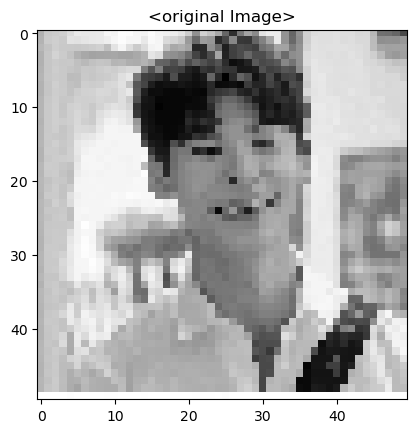

In [125]:
### 시각화
import matplotlib.pyplot as plt

### 입력 그림 (3D-> 2D)
grayImg = grayT.squeeze()
plt.imshow(X=grayImg, cmap='gray')
plt.title(label = '<original Image>')
plt.show()

[First Layer]


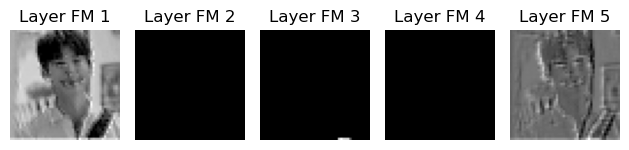

[Second Layer]


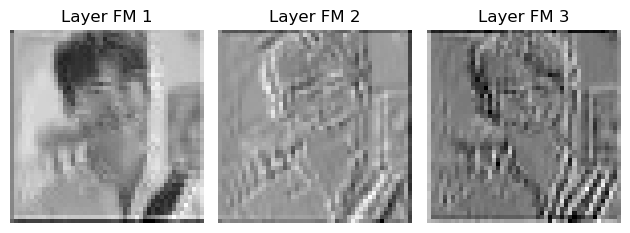

[Final Layer]


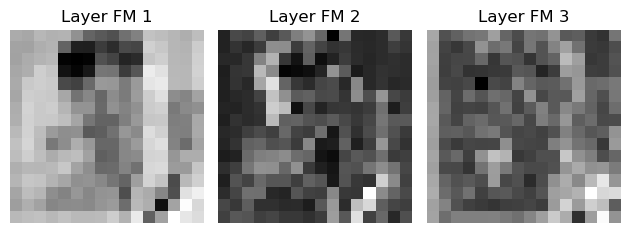

In [151]:
# 첫번째 Conv2D Layer 추출 피처맵
def print_featuremap(fm_tensor, cols, layer_name) :
    print(f'[{layer_name} Layer]')
    
    # 시각화
    for idx in range(fm_tensor.shape[0]):
        plt.subplot(1,cols,idx+1)
        plt.imshow(X=fm_tensor[idx].detach().numpy(), cmap='gray')
        plt.title(label=f'Layer FM {idx+1}') 
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print_featuremap(relu1, 5, 'First')
print_featuremap(relu2, 3, 'Second')
print_featuremap(mp1, 3, 'Final')

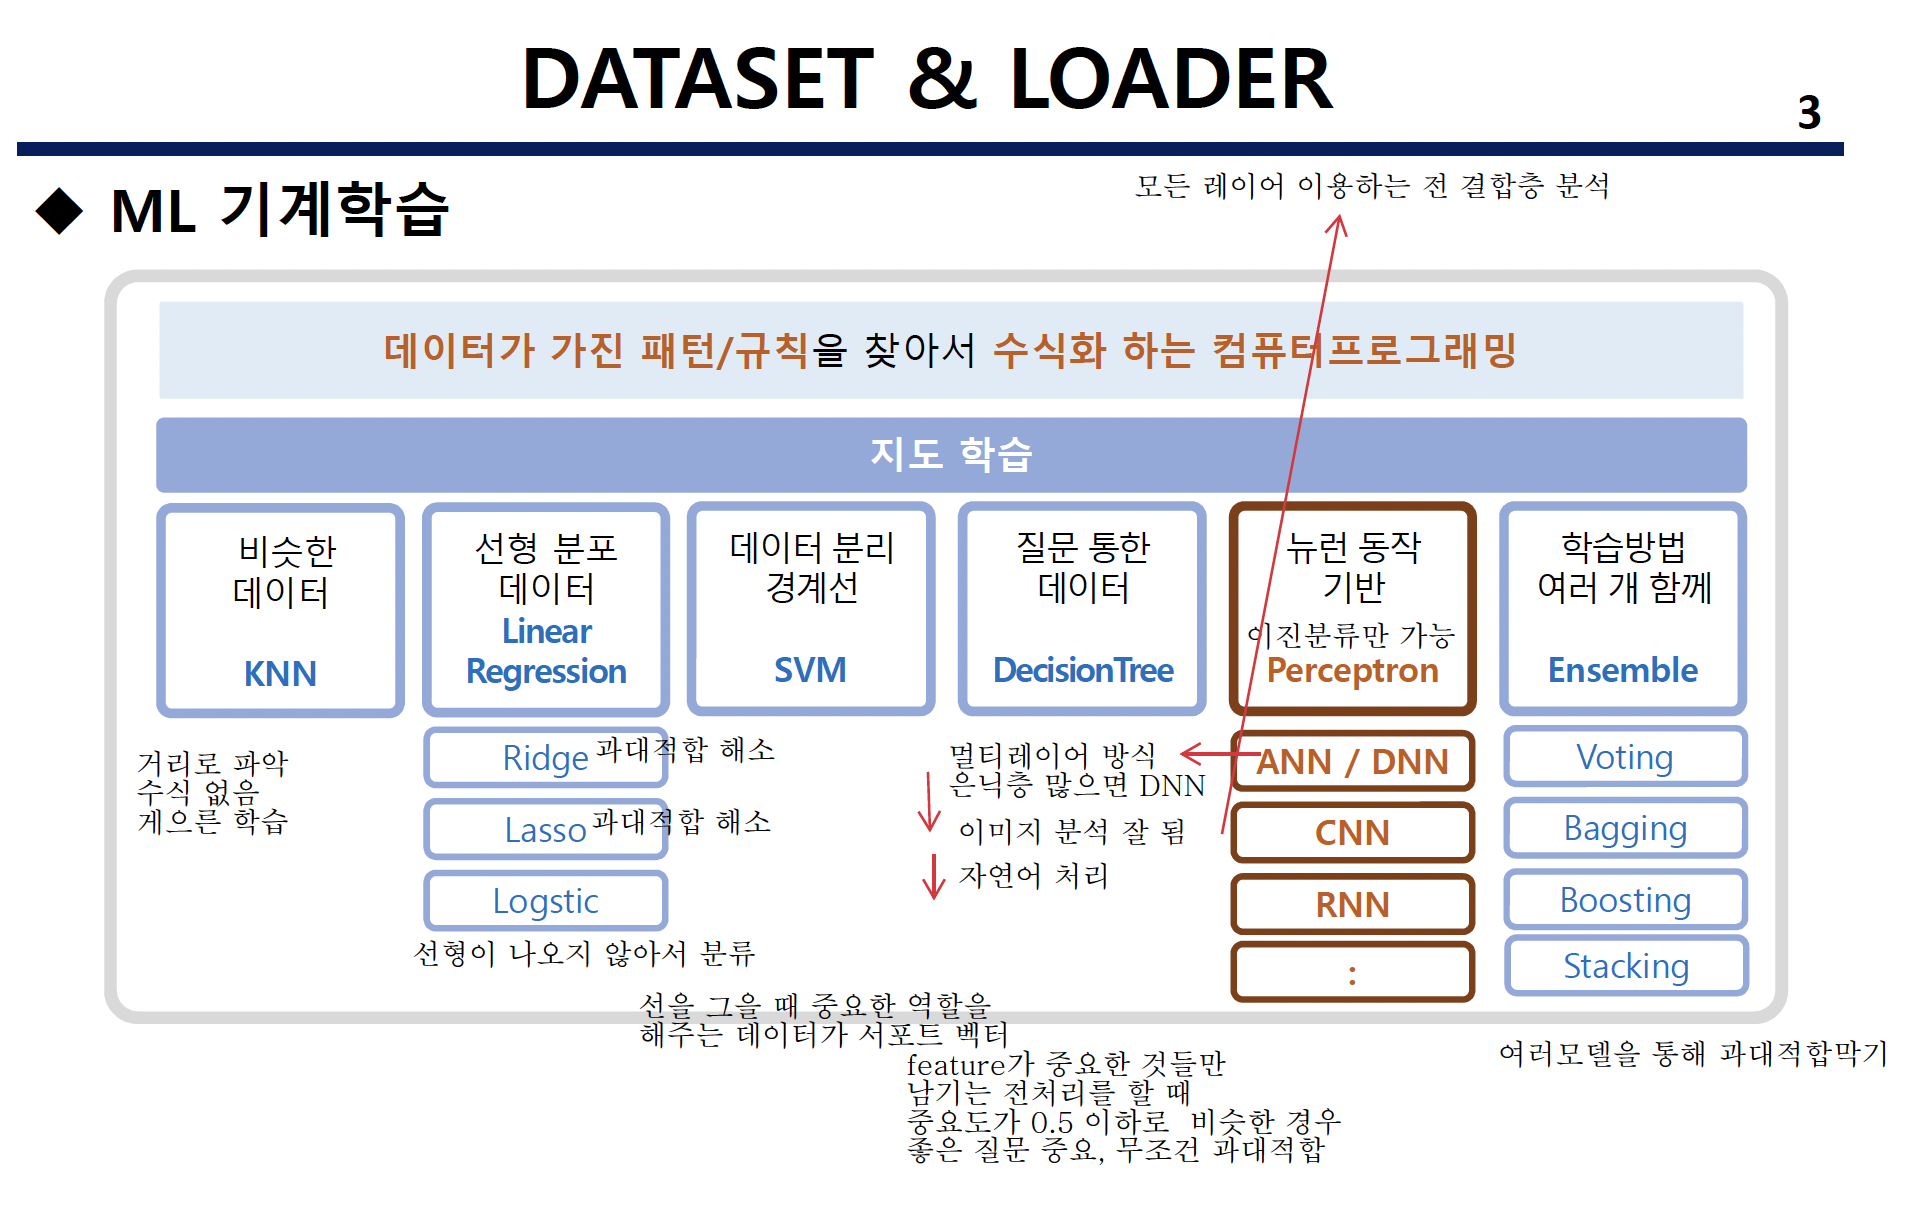